# Compute the _full_ likelihood 

This notebook focuses on computing the full likelihood, i.e., the one including nuisance parameters, that will be used in the MCMC. 

Given an input dataset, and a given model, it will compute its likelihood $ L(d | \theta, \phi) $.

Notation:
 - $L$ is the likelihood.
 - $\mathcal{L}$ is the log-likelihood.
 - $d$ is the data, the measured 1D power spectrum from BOSS / eBOSS / DESI / HIRES...  band powers $P_{ij}=P_{\rm 1D}(z_i, k_j)$, where $k_j$ has units of velocity ($s/km$). 
 - $\theta$ are the parameters describing the linear power spectrum.
 - $\phi$ are the nuisance parameters, describing the mean flux, temperature, pressure... 

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import fit_pk
import lya_results
import camb

### Cosmological parameters $\theta$

We will use a maximum of five parameters to describe the linear power spectrum across the redshift range of interest.

Three of them will describe the linear power at $z_\star$, in velocity units (km/s). We will use a Taylor expansion of the logarithm of the linear power around $k_p = 0.009$ s/km. 

$$ \Delta_p^2 = \frac{k_p^3}{2 \pi^2} P_L(z_\star,k_p) $$

$$ n_p = \frac{\partial \log P_L(z_\star, k)}{\partial \log(k) } \Bigr\rvert_{k_p} $$

$$ \alpha_p = \frac{\partial^2 \log P_L(z_\star, k)}{\partial \log^2(k) } \Bigr\rvert_{k_p} $$


$$ f_\star = f(z_\star) = \frac{\partial \log D(z)}{\partial \log a(z)} \Bigr\rvert_{z_\star} $$

$$ g_\star = g(z_\star) = \frac{\partial \log H(z)}{\partial \log (1+z)^{3/2}} \Bigr\rvert_{z_\star} $$


$$ \theta = \{ \Delta_p^2, n_p, \alpha_p, f_\star, g_\star \} $$

In [2]:
# specify cosmology
cosmo = fit_pk.get_cosmology(mnu=0.3,H0=73.0,ns=0.97) #,omk=0.02)
fit_pk.print_info(cosmo)
# get parameters describing the linear power spectrum
z_star=3.0
kp_kms=0.009
linP_params=fit_pk.parameterize_cosmology(cosmo,z_star=z_star,kp_kms=kp_kms)
print('linP_params',linP_params)
# compute CAMB results (for testing)
results=camb.get_results(cosmo)

H0 = 73.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.00322 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.97
linP_params {'f_star': 0.96439447908106624, 'g_star': 0.9603164285445334, 'linP_kms': poly1d([ -0.10707297,  -2.29803848,  15.99861713])}


### Nuisance parameters $\phi$

For now, let us assume that we only have nuisance parameters associated to the mean flux as a function of redshift. 
There are several parameterizations possible. If interested, take a look at the notebook mean_flux.ipynb.
 
For this notebook, we will use three parameters to describe the mean flux:
$$ \ln \tau_{\rm eff}(z) = \ln \tau_\star + n_\tau \ln \left( \frac{1+z}{1+z_\star} \right) + \alpha_\tau \ln^2 \left( \frac{1+z}{1+z_\star} \right) $$

The nuisance parameters, therefore, will be 
$$ \phi = \{ \tau_\star , n_\tau , \alpha_\tau \} $$

In [3]:
# specify values for mean flux model
nuisance_params={'z_star':3.0,'tau_star':0.42,'n_tau':3.5,'alpha_tau':-1.0}

### Dataset

We will work with 1D power spectrum, measured at independent redshift bins, and at several wavenumbers. 

In this notebook, we will have only three redshift bins, and we will have ten wavenumbers.

In [4]:
def get_data(verbose=False):
    # specify redshift bins
    zmin=2.0
    zmax=4.0
    dz=1.0
    Nz=int((zmax-zmin)/dz)+1
    z_bins = np.linspace(zmin,zmax,num=Nz,endpoint=True)
    if verbose:
        print('z_bins =',z_bins)
    # specify wavenumbers (in units of km/s)
    kmin_kms=0.001
    kmax_kms=0.02
    Nk=10
    k_bins=np.logspace(np.log10(kmin_kms),np.log10(kmax_kms),num=Nk)
    if verbose:
        print('k_bins =',k_bins)
    # fake power measured
    P1D = 100*np.ones([Nz,Nk])
    # fake, diagonal covariance 
    P1D_cov = np.ones([Nz,Nk])
    # store everything in dictionary
    data = {'z_bins':z_bins, 'k_bins':k_bins, 'P1D':P1D, 'P1D_cov':P1D_cov}
    return data

In [5]:
data = get_data()

### Redshift sub-likelihoods

The 1D power measured in different redshift bins are, to first order, uncorrelated. 
This allows us to describe the total likelihood as a product of the sub-likelihood for each redshift:
    
$$ \mathcal{L} (d | \theta, \phi) = \sum_{i=0}^{N_z} \mathcal{L_i} (d_i | \theta, \phi) $$

In [6]:
def full_loglike(data, linP_params, nuisance_params, cosmo_fid):
    # get parameters for the fiducial cosmology
    linP_params_fid=fit_pk.parameterize_cosmology(cosmo_fid,z_star=z_star,kp_kms=kp_kms)
    # sum contribution from each redshift
    loglike=0
    # get number of redshift bins
    Nz = len(data['z_bins'])
    for iz in range(Nz):
        loglike += loglike_z(iz,data,linP_params,nuisance_params,cosmo_fid,linP_params_fid)
    return loglike

In [7]:
def loglike_z(iz, data, linP_params, nuisance_params, cosmo_fid, linP_params_fid):
    z = data['z_bins'][iz]
    k_kms = data['k_bins']
    P1D_data = data['P1D'][iz]
    P1D_cov = data['P1D_cov'][iz]
    # get theoretical prediction for this redshift bin
    P1D_model=model_P1D_kms(z,k_kms,linP_params,nuisance_params,cosmo_fid,linP_params_fid)
    # for now assume diagonal covariance
    chi2 = np.sum((P1D_data-P1D_model)**2/P1D_cov)
    loglike=-0.5*chi2
    return loglike

### The role of the fiducial cosmology

Our claim is that all the cosmological dependence can be compressed into the set of 5 parameters discussed above:

$$ \theta = \{ \Delta_p^2, n_p, \alpha_p, f_\star, g_\star \} $$

A set of values $\theta$ uniquely describe the linear power spectrum over all redshifts and scales of interest, in velocity units. For technical reasons that will be aparent later on, it is convenient sometimes to compute the Hubble parameter in the input cosmology, $H_\star=H(z_\star)$. It is not possible to reconstruct this from the $\theta$ parameters, and we will use therefore an arbitrary value, $H_\star^0$. We will show that the results do not depend on the choice of this value. 

We will also use a fiducial cosmology to compute the linear power, and we will use the differences $\theta-\theta^0$
parameters to go from the fiducial to the input cosmology. 

In [8]:
# setup fiducial cosmology
cosmo_fid = fit_pk.get_cosmology()
fit_pk.print_info(cosmo_fid)
# get parameters describing the fiducial linear power spectrum
linP_params_fid=fit_pk.parameterize_cosmology(cosmo_fid,z_star=z_star,kp_kms=kp_kms)
print('linP_params_fid',linP_params_fid)
# compute CAMB results
results_fid=camb.get_results(cosmo_fid)
# get Hubble at z_star for fiducial cosmology, used to compute kp_Mpc
H_star_fid=results_fid.hubble_parameter(z_star)
A_star_fid=H_star_fid/(1+z_star)
kp_Mpc=kp_kms*A_star_fid
print('kp_Mpc =',kp_Mpc)

H0 = 67.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.00064 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96
linP_params_fid {'f_star': 0.97891957965698961, 'g_star': 0.9679033230853668, 'linP_kms': poly1d([ -0.10816234,  -2.30481498,  16.06510418])}
kp_Mpc = 0.6914784430888169


### Reconstructing the linear power, in comoving units

The simulations have a constant box size in comoving coordinates, and if we measure power spectra there in comoving units we can have the same random seed in all boxes and share the cosmic variance in all boxes. 

For this reason we decide to use comoving coordinates in the emulator, and we need therefore to reconstruct the linear power in comoving units for each input cosmology. 

$$ P(z,k) = \frac{1}{A^3(z)} Q(z,q=k/A(z)) $$

where $A(z)=H(z)/(1+z)$.

In the notebook compress_linPk_kms we discuss how to compute $Q(z,q)$ from the set of parameters $\theta$ and a fiducial cosmology, so all we need to do now is compute $A(z)$ for the input cosmology. We will use the following relation:

$$ \frac{A(z)}{A_\star} \frac{A_\star^0}{A^0(z)} = 1 + \frac{3}{2} (g_\star-g_\star^0) \frac{\Delta z}{1+z_\star}$$

and as discussed above, we will make the arbitrary choice of $A_\star = A_\star^0$, to get the final expression:

$$ A(z) = A^0(z) \left( 1 + \frac{3}{2} (g_\star-g_\star^0) \frac{\Delta z}{1+z_\star} \right) $$

We can use this expression to go back and forth between comoving and velocity coordinates in our input cosmology

In [9]:
def reconstruct_Hubble(z,results_fid,linP_params_fid,linP_params,z_star):
    # compute difference in acceleration
    g_star=linP_params['g_star']
    g_star_fid=linP_params_fid['g_star']
    # compute Hubble parameter in fiducial cosmology
    Hz_fid = results_fid.hubble_parameter(z)
    # compute Hubble parameter in input cosmology
    Hz = Hz_fid * (1+3/2*(g_star-g_star_fid)*(z-z_star)/(1+z_star))
    return Hz

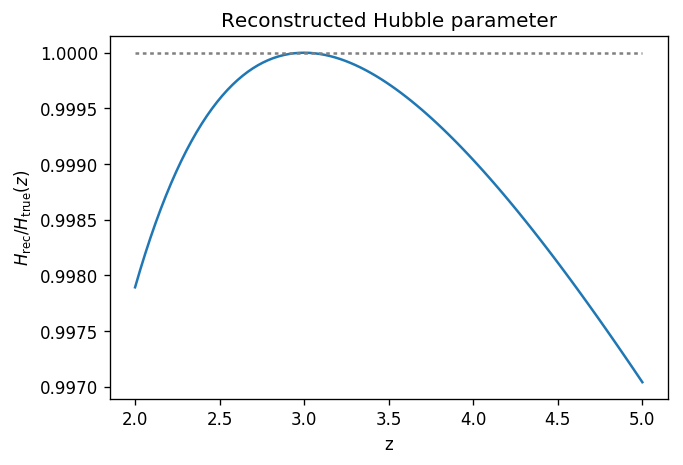

In [10]:
# plot reconstructed Hubble parameter
z=np.linspace(2.0,5.0,100)
Hz_rec=reconstruct_Hubble(z,results_fid,linP_params_fid,linP_params,z_star)
# compute true value, normalized properly to H_star
Hz_true=results.hubble_parameter(z)
H_star=results.hubble_parameter(z_star)
# make plot
plt.figure()
plt.plot(z,Hz_rec/H_star_fid/Hz_true*H_star)
plt.plot(z,np.ones_like(z),':',color='gray')
plt.title('Reconstructed Hubble parameter')
plt.xlabel('z')
plt.ylabel(r'$H_{\rm rec}/H_{\rm true}(z)$')

In [11]:
def reconstruct_linP_Mpc(z,k_Mpc,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms):
    # compute CAMB results for fiducial cosmology
    results_fid=camb.get_results(cosmo_fid)
    # reconstruct Hubble parameter at the redshfit, to convert wavenumbers to velocity units
    Hz=reconstruct_Hubble(z,results_fid,linP_params_fid,linP_params,z_star)
    Az=Hz/(1+z)
    k_kms=k_Mpc/Az
    # reconstruct linear power in velocity units
    rec_linP_kms=fit_pk.reconstruct_linP_kms([z],k_kms,cosmo_fid,linP_params,z_star,kp_kms)
    # note that we expect z to be a float, not a list
    rec_linP_Mpc=rec_linP_kms[0]/Az**3
    return rec_linP_Mpc

In [12]:
# test reconstructed linear power
zs=np.array([2.0,3.0,5.0])
# compute true linear power (will interpolate later)
k_Mpc,zs_out,linP_Mpc=fit_pk.get_linP_Mpc(cosmo,zs=zs)
# compute ratio of H_star in both cosmologies (arbitrary choice discussed above)
H_factor=H_star/H_star_fid
print('H_factor',H_factor)

Note: redshifts have been re-sorted (earliest first)
H_factor 1.0129680693508651


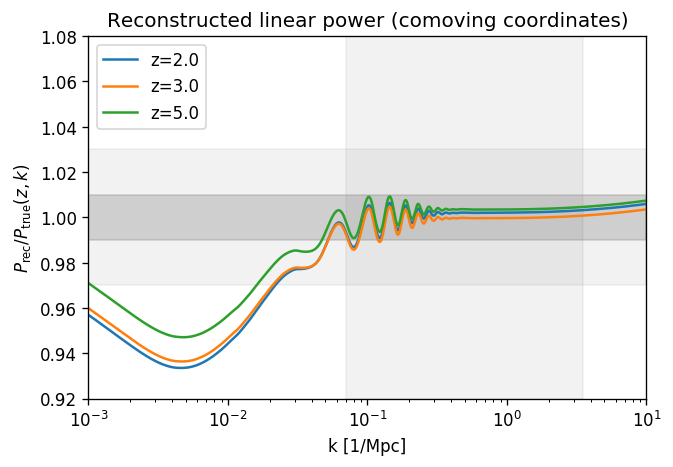

In [13]:
# plot ratio of reconstructed power
plt.figure()
for iz in range(len(zs)):
    z=zs_out[iz]
    # reconstruct linear power (with an arbitrary choice of H_star)
    linP_Mpc_rec=reconstruct_linP_Mpc(z,k_Mpc,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms)
    linP_Mpc_true=np.interp(k_Mpc*H_factor,k_Mpc,linP_Mpc[iz])*H_factor**3
    # make plot
    plt.semilogx(k_Mpc,linP_Mpc_rec/linP_Mpc_true,label='z='+str(z))
plt.legend()
plt.title('Reconstructed linear power (comoving coordinates)')
plt.xlabel('k [1/Mpc]')
plt.ylabel(r'$P_{\rm rec}/P_{\rm true}(z,k)$')
plt.axhspan(0.97,1.03,alpha=0.1, color='gray')
plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
plt.axvspan(0.7*0.1,0.7*5.0,alpha=0.1, color='gray')
plt.xlim(1.e-3,1e1)
plt.ylim(0.92,1.08);

In [14]:
def fit_linP_Mpc(z,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms,kp_Mpc):
    # will reconstruct the linear power in the range (0.5 kp_Mpc < k_Mpc < 2.0 kp_Mpc) to later do the fit
    kmin_Mpc=0.5*kp_Mpc
    kmax_Mpc=2.0*kp_Mpc
    k_Mpc = np.logspace(np.log10(kmin_Mpc),np.log10(kmax_Mpc),100)
    # reconstruct linear power spectrum for input cosmology
    linP_Mpc_rec=reconstruct_linP_Mpc(z,k_Mpc,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms)
    linP_Mpc_params=fit_pk.fit_polynomial(kmin_Mpc/kp_Mpc,kmax_Mpc/kp_Mpc,k_Mpc/kp_Mpc,linP_Mpc_rec,deg=2)
    return linP_Mpc_params

In [15]:
# test 
z=4.0
linP_Mpc_params=fit_linP_Mpc(z,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms,kp_Mpc)
print(np.array(linP_Mpc_params))

[-0.10700416 -2.29811629  2.54203868]


In [16]:
def emulate_P1D_Mpc(mf,linP_Mpc,kp_Mpc):
    print('emulate',mf,np.array(linP_Mpc))
    # do magic
    k1D_Mpc=np.linspace(0.1,10.0,100)
    P1D_Mpc=k1D_Mpc
    return k1D_Mpc,P1D_Mpc

In [17]:
def model_P1D_kms(z,k_kms,linP_params,nuisance_params,cosmo_fid,linP_params_fid):
    # compute mean flux at this redshift
    mf = np.exp(-tau_effective(z,nuisance_params))
    # get the parameters describing the linear power, at the redshift, in comoving units
    linP_Mpc_params=fit_linP_Mpc(z,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms,kp_Mpc)
    # ask the emulator to predict the 1D flux power spectrum, in Mpc
    k_Mpc,P1D_Mpc=emulate_P1D_Mpc(mf,linP_Mpc_params,kp_Mpc)
    # reconstruct Hubble parameter at the redshfit, to convert wavenumbers to velocity units
    Hz=reconstruct_Hubble(z,results_fid,linP_params_fid,linP_params,z_star)
    Az=Hz/(1+z)
    k_kms_emu=k_Mpc/Az    
    P1D_kms_emu=P1D_Mpc*Az
    # interpolate to compute the desired input wavenumbers
    P1D_kms=np.interp(k_kms,k_kms_emu,P1D_kms_emu)
    return P1D_kms

In [18]:
def tau_effective(z,nuisance_params):
    z_star=nuisance_params['z_star']
    tau_star=nuisance_params['tau_star']
    n_tau=nuisance_params['n_tau']
    alpha_tau=nuisance_params['alpha_tau']
    x = np.log((1+z)/(1+z_star))
    ln_tau = np.log(tau_star) + n_tau*x + alpha_tau*x**2
    return np.exp(ln_tau)

In [19]:
full_loglike(data,linP_params,nuisance_params,cosmo_fid)

emulate 0.86826300411 [-0.10698824 -2.298178    3.52409815]
emulate 0.657046819815 [-0.10699663 -2.29814611  2.9737913 ]
emulate 0.417868490118 [-0.10700416 -2.29811629  2.54203868]


-73057.707047699922

### Map likelihood parameters to emulator parameters

In [20]:
Nz=16
zs=np.linspace(2.0,5.0,Nz)
print(zs)

[ 2.   2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8
  5. ]


In [21]:
def emulator_calls(zs, linP_params, nuisance_params, cosmo_fid):
    # compute CAMB results for fiducial cosmology
    results_fid=camb.get_results(cosmo_fid)
    # get Hubble at z_star for fiducial cosmology, used to compute kp_Mpc
    H_star_fid=results_fid.hubble_parameter(z_star)
    A_star_fid=H_star_fid/(1+z_star)
    kp_Mpc=kp_kms*A_star_fid
    print('kp_Mpc =',kp_Mpc)
    # get parameters for the fiducial cosmology
    linP_params_fid=fit_pk.parameterize_cosmology(cosmo_fid,z_star=z_star,kp_kms=kp_kms)
    # collect emulator calls at each redshift
    calls=[]
    for z in zs:
        calls.append(emulator_call_z(z,linP_params,nuisance_params,cosmo_fid,linP_params_fid,kp_Mpc))
    return calls

In [22]:
def emulator_call_z(z, linP_params, nuisance_params, cosmo_fid, linP_params_fid,kp_Mpc):
    # get point in emulator parameter space that will be called 
    call = {'z':z}
    # compute mean flux at this redshift
    mf = np.exp(-tau_effective(z,nuisance_params))
    call['mean_flux']=mf
    # get the parameters describing the linear power, at the redshift, in comoving units
    linP_Mpc_params=fit_linP_Mpc(z,cosmo_fid,linP_params_fid,linP_params,z_star,kp_kms,kp_Mpc)
    call['lnA_p_Mpc']=linP_Mpc_params[0]
    call['n_p_Mpc']=linP_Mpc_params[1]
    call['alpha_p_Mpc']=linP_Mpc_params[2]
    print(call)
    return call

In [23]:
calls=emulator_calls(zs, linP_params, nuisance_params, cosmo_fid)

kp_Mpc = 0.6914784430888169
{'z': 2.0, 'mean_flux': 0.86826300411039337, 'lnA_p_Mpc': 3.5240981523541777, 'n_p_Mpc': -2.2981779993989067, 'alpha_p_Mpc': -0.10698824205465272}
{'z': 2.2000000000000002, 'mean_flux': 0.83277225754584294, 'lnA_p_Mpc': 3.4016848025807866, 'n_p_Mpc': -2.2981714020034891, 'alpha_p_Mpc': -0.10698978608474145}
{'z': 2.3999999999999999, 'mean_flux': 0.79326073617540727, 'lnA_p_Mpc': 3.2860455625763527, 'n_p_Mpc': -2.2981649222591414, 'alpha_p_Mpc': -0.10699158802935571}
{'z': 2.6000000000000001, 'mean_flux': 0.750315685895103, 'lnA_p_Mpc': 3.1765476340913934, 'n_p_Mpc': -2.2981586101075209, 'alpha_p_Mpc': -0.10699329841028485}
{'z': 2.7999999999999998, 'mean_flux': 0.70464763245059714, 'lnA_p_Mpc': 3.0726288175674359, 'n_p_Mpc': -2.2981522880514995, 'alpha_p_Mpc': -0.10699482966193928}
{'z': 3.0, 'mean_flux': 0.65704681981505675, 'lnA_p_Mpc': 2.9737913035104744, 'n_p_Mpc': -2.2981461078916947, 'alpha_p_Mpc': -0.10699662691467879}
{'z': 3.2000000000000002, 'mean_

In [24]:
# collect values of parameters in each call, to make plots
Nc=len(calls)
call_F=np.empty(Nc)
call_DL2_p=np.empty(Nc)
call_n_p=np.empty(Nc)
call_alpha_p=np.empty(Nc)
call_z=np.empty(Nc)
for i in range(Nc):
    call=calls[i]
    call_z[i]=call['z']
    call_F[i]=call['mean_flux']
    lnA_p=call['lnA_p_Mpc']
    DL2_p=np.exp(lnA_p)*kp_Mpc**3/(2*np.pi**2)
    call_DL2_p[i]=DL2_p
    call_n_p[i]=call['n_p_Mpc']
    call_alpha_p[i]=call['alpha_p_Mpc']    

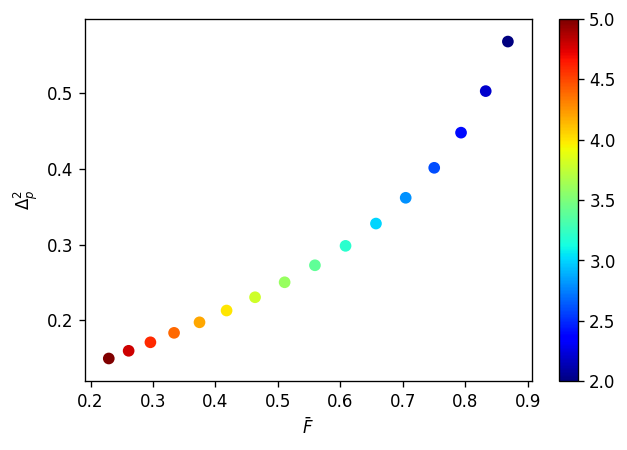

In [25]:
plt.figure()
plt.scatter(call_F,call_DL2_p,c=call_z,cmap=mpl.cm.jet)
plt.xlabel(r'$\bar F$')
plt.ylabel(r'$\Delta_p^2$')
plt.colorbar()

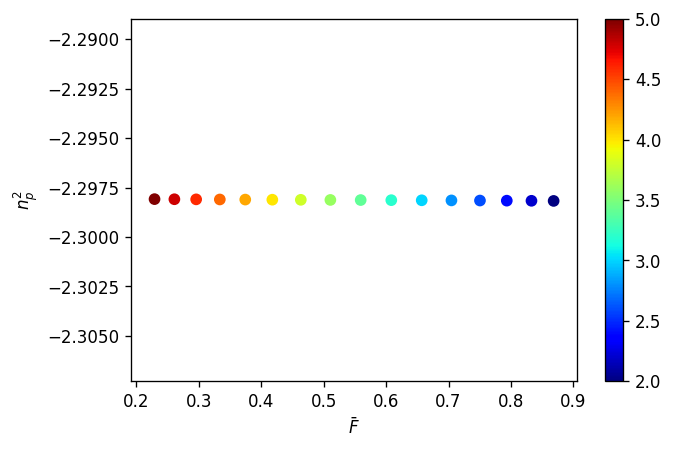

In [26]:
plt.figure()
plt.scatter(call_F,call_n_p,c=call_z,cmap=mpl.cm.jet)
plt.xlabel(r'$\bar F$')
plt.ylabel(r'$n_p^2$')
plt.colorbar()